# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different number of topics and evaluating coherence.

In [1]:
import psycopg2
import numpy 
from time import time
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim

n_samples = 100000
n_iterations = 250
test_ratio = 0.2

In [2]:
def log(message):
    print(message, flush=True)

In [3]:
t0 = time()
print("Connecting to DB...")
conn = psycopg2.connect("dbname='peanut_prod' user='mezis' host='frolic.local' password='av85ck4g'")
cur = conn.cursor()

print("Loading dataset...")
cur.execute(f"""
    SELECT CONCAT_WS(' ', title, body) AS text
    FROM post p
    JOIN users u ON u.id = p.author_id
    --JOIN post_stats ps ON ps.id = p.id AND ps.view_count > 50
    WHERE TRUE
      AND u.account_status = 'active'
      AND p.status = 'active'
    ORDER BY p.id DESC
    LIMIT {n_samples}
""")
data_samples = [row[0] for row in cur.fetchall()]

print("done in %0.3fs." % (time() - t0))
print("%d samples" % len(data_samples))

Connecting to DB...
Loading dataset...
done in 0.679s.
100000 samples


In [4]:
print("Preparing text preprocessing...")
import re

t0 = time()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

class MyPreprocessor:
    def __call__(self, doc):
        return doc.lower()

class MyTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.stopwords = frozenset(
            nltk.corpus.stopwords.words('english') + """
                n't
                anyone
                everyone
                feel like want get
            """.split()
        )
        self.re = re.compile(r"[a-z0-9]")
        
    def __call__(self, doc):
        return [token for token in [self.filter(token) for token in self.tokenize(doc)] if token]
    
    def tokenize(self, doc):
        return nltk.word_tokenize(doc.lower());
    
    def filter(self, token):
        if token in self.stopwords:
            return
        if not self.re.match(token):
            return
        return self.wnl.lemmatize(token)

print("done in %0.3fs." % (time() - t0))

Preparing text preprocessing...
done in 0.148s.


[nltk_data] Downloading package punkt to /home/mezis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mezis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mezis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mezis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from tqdm import tqdm
import multiprocessing

print('Tokenizing...')
tokenizer = MyTokenizer()
data_tokenized = []
pool = multiprocessing.Pool(processes=8)
for tokenized in pool.imap_unordered(tokenizer, tqdm(data_samples)):
    data_tokenized.append(tokenized)

# remove zero-length documents
data_tokenized = [d for d in data_tokenized if len(d) > 0]

n_train = int(len(data_tokenized) * (1 - test_ratio))
data_train = data_tokenized[: n_train]
data_test  = data_tokenized[n_train :]

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

print(f'{len(data_train)} training documents')
print(f'{len(data_test)} test documents')

Tokenizing...


100%|██████████| 100000/100000 [00:10<00:00, 9956.05it/s]


Building gensim corpus...
79543 training documents
19886 test documents


In [6]:
import tomotopy as tp

model = tp.LDAModel(
    tw=tp.TermWeight.ONE,
    k=20,
    min_cf=200,
    seed=0
)

for tokens in tqdm(data_train):
    model.add_doc(tokens)

100%|██████████| 79543/79543 [00:00<00:00, 133825.35it/s]


In [7]:
# https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
# https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/scripts/model_funcs.py

def get_topic_words(model, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    model:obj -> trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays2 with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = range(model.k)
    
    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        try:
            if not model.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        except AttributeError: 
            pass
        
        topic_wp = model.get_topic_words(k, top_n=top_n)

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, vocab, documents, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    vocab: gensim.corpora.Dictionary
    documents: list of list of strings
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    3-tuple,
        float -> coherence value
        float list -> per-topic coherence
        float list -> per-topic coherence deviation
    '''
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens = [w for w,p in tups]
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    cm = gensim.models.CoherenceModel(
        topics=topic_list,
        dictionary=vocab,
        texts=documents, 
        coherence=coherence_type,
        processes=8)
    
    return cm.get_coherence()


In [8]:
#
# FIXME:
# only consider a topic when its score is > some threshold (2x 1/20 ?)

def topic_counts(model, top_n):
    """For each topic, count posts where the topic figure in the `top_n` topics
    
    Returns:
    dict of topic_id (int), posts (int)
    """
    counts = {}
    threshold = 2.0 / model.k
    for k in range(model.k):
        counts[k] = 0
    for doc in tqdm(model.docs):
        for k, v in doc.get_topics(top_n=top_n):
            if v < threshold: next
            counts[k] += 1
    return counts

In [9]:
# http://qpleple.com/perplexity-to-evaluate-topic-models/

def model_perplexity(model, samples):
    count = 0
    docs = [model.make_doc(s) for s in samples]
    _, log_likelihoods = model.infer(doc=docs)
    lengths = [len(s) for s in samples]
    
    assert len(lengths) == len(log_likelihoods)
    return numpy.sum(numpy.array(log_likelihoods)) / numpy.sum(numpy.array(lengths))


In [10]:
train_perplexity = {}
test_perplexity = {}
coherence_c_v = {}
coherence_u_mass = {}


for iter in tqdm(range(0, n_iterations)):
    model.train(1)
    if not (iter <= 25 or iter % 10 == 0): next
    
    train_perplexity[iter] = model_perplexity(model, data_train)
    test_perplexity[iter] = model_perplexity(model, data_test)

    c = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='c_v')
    coherence_c_v[iter] = c

    c = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='u_mass')
    coherence_u_mass[iter] = c


100%|██████████| 250/250 [38:16<00:00,  9.19s/it]


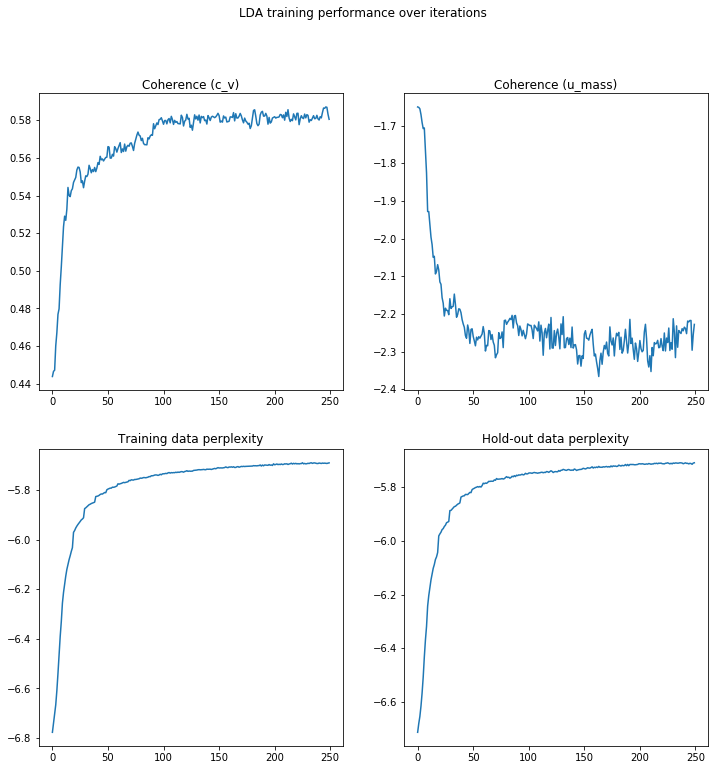

In [15]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('LDA training performance over iterations')

x = list(coherence_c_v.keys())
y = list(coherence_c_v.values())

plt.subplot(221)
plt.plot(x,y)
plt.title('Coherence (c_v)')

y = list(coherence_u_mass.values())

plt.subplot(222)
plt.plot(x,y)
plt.title('Coherence (u_mass)')

y = list(train_perplexity.values())

plt.subplot(223)
plt.plot(x,y)
plt.title('Training data perplexity')

y = list(test_perplexity.values())

plt.subplot(224)
plt.plot(x,y)
plt.title('Hold-out data perplexity')

plt.show()

